# Challenge문제 : ROAR 구현하기

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 29.6 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 100
learning_rate = 0.001
num_epochs = 20

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



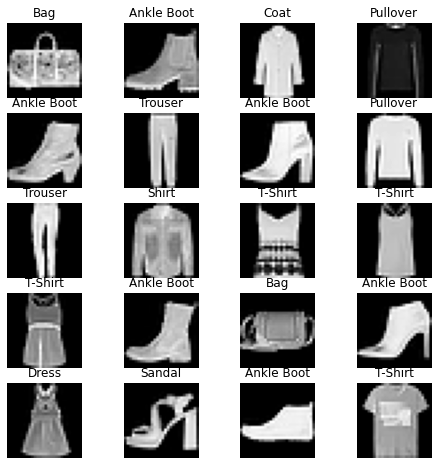

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download = True, train = True, transform = transform)
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download = True, train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss();

model = FashionCNN();
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#모델 학습
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)        
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 1.778867244720459, Accuracy: 69.8499984741211%
Iteration: 1000, Loss: 1.7027052640914917, Accuracy: 73.15999603271484%
Iteration: 1500, Loss: 1.6942148208618164, Accuracy: 74.87999725341797%
Iteration: 2000, Loss: 1.7609797716140747, Accuracy: 75.7699966430664%
Iteration: 2500, Loss: 1.7141727209091187, Accuracy: 76.72000122070312%
Iteration: 3000, Loss: 1.686139702796936, Accuracy: 77.54999542236328%
Iteration: 3500, Loss: 1.7149081230163574, Accuracy: 78.02999877929688%
Iteration: 4000, Loss: 1.6864352226257324, Accuracy: 78.94999694824219%
Iteration: 4500, Loss: 1.616904854774475, Accuracy: 78.25999450683594%
Iteration: 5000, Loss: 1.7020690441131592, Accuracy: 79.8499984741211%
Iteration: 5500, Loss: 1.6865061521530151, Accuracy: 79.79999542236328%
Iteration: 6000, Loss: 1.6394050121307373, Accuracy: 80.32999420166016%
Iteration: 6500, Loss: 1.659062385559082, Accuracy: 80.97000122070312%
Iteration: 7000, Loss: 1.6092878580093384, Accuracy: 80.72999572753906%


In [ ]:
x, y = next(iter(test_loader))
predict_list = []
for num in range(10):
    img = x[num]
    # plt.imshow(img.view(28,28,1))
    img = img.to(device)
    groundtruth = labels_map[y[num].item()]
    print('GroundTruth : ', groundtruth)
    with torch.no_grad():
        model.eval()
        outputs = model(img.unsqueeze(0))            
        predictions = torch.max(outputs, 1)[1].to(device)
        predict = labels_map[predictions.item()]
        predict_list.append(predictions.item())
        print('Prediction  : ',predict)
    print('==========================')

GroundTruth :  Ankle Boot
Prediction  :  Ankle Boot
GroundTruth :  Pullover
Prediction  :  Pullover
GroundTruth :  Trouser
Prediction  :  Trouser
GroundTruth :  Trouser
Prediction  :  Trouser
GroundTruth :  Shirt
Prediction  :  Shirt
GroundTruth :  Trouser
Prediction  :  Trouser
GroundTruth :  Coat
Prediction  :  Shirt
GroundTruth :  Shirt
Prediction  :  Shirt
GroundTruth :  Sandal
Prediction  :  Sandal
GroundTruth :  Sneaker
Prediction  :  Sneaker


In [ ]:
import shap
x = x.to(device)
test_images = x[:10]
background = x[10:]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

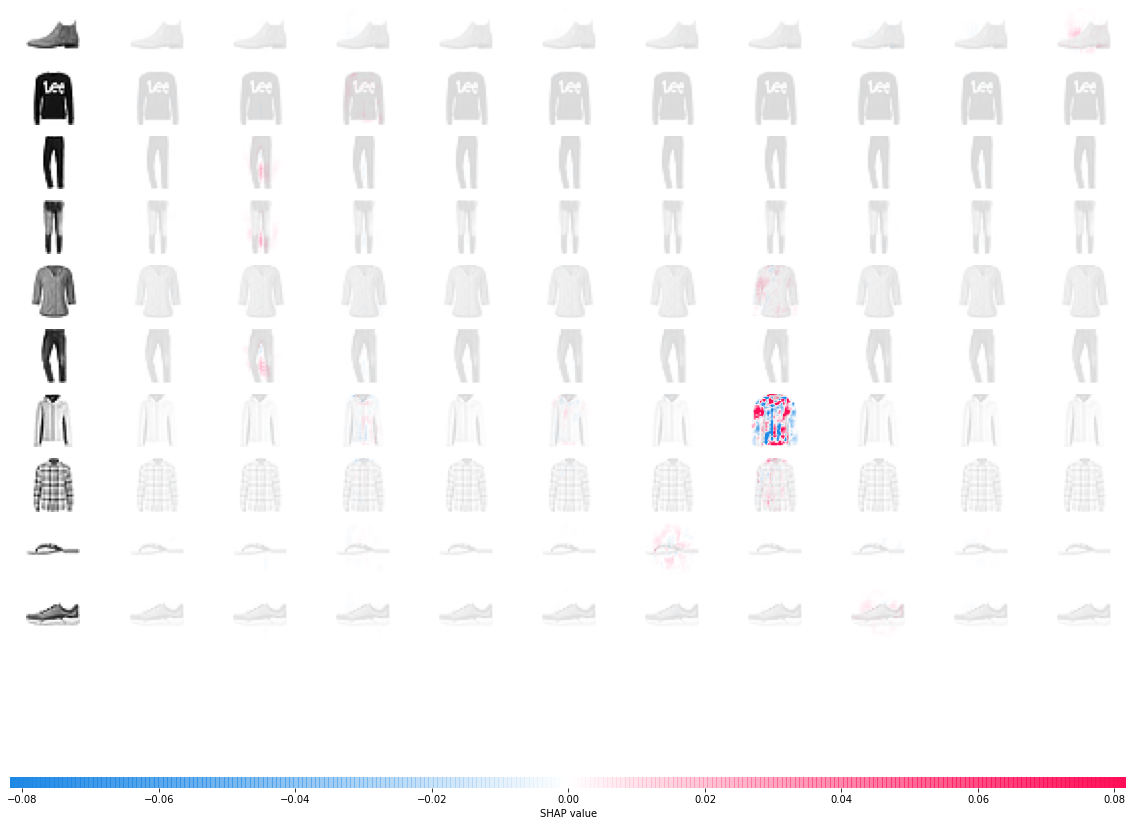

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
edit_image = []
for i, p in enumerate(predict_list):
    s = shap_numpy[p][i]
    for x1 in range(len(test_numpy[i])):
        for y1 in range(len(test_numpy[i][0])):
            if s[x1][y1] > 0:
                test_numpy[i][x1][y1] = 0
    edit_image.append(test_numpy[i])

In [ ]:
dataset = TensorDataset(torch.FloatTensor(edit_image),torch.LongTensor(predict_list))
dataloader = DataLoader(dataset, batch_size = 10)

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
#모델 학습
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

model.train()
for epoch in range(5):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 1):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)        
                test = Variable(images.view(-1, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 1):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 1, Loss: 2.155212879180908, Accuracy: 82.16999816894531%
Iteration: 2, Loss: 2.251430034637451, Accuracy: 82.12999725341797%
Iteration: 3, Loss: 2.312513828277588, Accuracy: 81.91999816894531%
Iteration: 4, Loss: 2.3544578552246094, Accuracy: 81.83999633789062%
Iteration: 5, Loss: 2.292954444885254, Accuracy: 81.75%
